# Telecommnication Churn Prediction

In this project, we use supervised learning models to identify customers who are likely to stop using telecommunication service in the future. Furthermore, we will analyze top factors that influence user retention from model itself. The dataset source is https://www.kaggle.com/pangkw/telco-churn/home

# Summary
In Part I Data Exploration, we first learn that this is a binary classification problem with an imbalanced dataset. Then we display pairplot and correlation matrix represented as a heatmap. Nothing non-trivial stands out. After a simple data cleaning, we decide to define the feature types into major 4 categories:

Type |Feature | Pre-processing
--- |--- | ---
numeric | float or ordinal integers | standard scaling
binary | yes or no features |represented as 1 or 0
encoding | text categorical features | One-hot encoding

Each category receive individual pre-processing and are combined into a feature space for training. We also note that "customerID" definition is unclear and "PhoneService" is Yes for all samples. Therefore, these two features are dropped from this study. This pre-processing is done in Part 2.  

In Part 3, we select few representative classification models with 5-fold cross validation to evaluate their performance. The result is summarized below. It is clear that eXtreme Gradient Boosting (XGBOOST) is best in all metrics. Furthermore, a grid search method is used to explore different hyper-parameter can gain us 1% in accuracy (see "XGBOOST optimized"). It is concluded that XGBOOST with fine-tuned hyper-parameters is the best choice for this dataset.  


Model Name| CV Accuracy| Precision| Recall| F1 score|
--- |--- | ---|--- |--- | ---|
Logistic regression with L1	|0.893029	|0.690691	|0.476190	|0.563725
Logistic regression with L2	|0.893029	|0.686217	|0.484472	|0.567961
Random forest	            |0.913161	|0.854015	|0.484472	|0.618230
KNN	                        |0.893029	|0.757085	|0.387164	|0.512329
SVM	                        |0.916767	|0.836601	|0.530021	|0.648923
XGBOOST                 	|0.947716	|0.885287	|0.734990	|0.803167
XGBOOST optimized	        |0.956130	|0.933162	|0.751553	|0.832569



In Part 4, we deep dive into the feature importance extracted from the trained model. The top five predictive features are TotalDayMinutes, TotalEveMinutes, TotalIntlMinutes, CustomerServiceCalls and TotalNightMinutes. Four out of them are related to the call usage. In the distribution plot of TotalDayMinutes, we even recognize an extra peak at ~280 minutes, which is higher than average usage. This indicates heavy users may seek for a more discounted plan from the competitors. From CustomerServiceCalls feature, we notice that when a user make more than four service calls, they tend to be churned. This may be related to the customer service quality and trouble-shooting capability. 

In conclusion, we have trained various classification models for this churn prediction. XGBOOST provides the best performance in all metrics. In additional to the 95.6% prediction accuracy, we also note the company may provide a  discount plan for heavy users and investigate the customer service call quality. 

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Importance](#Part-4:-Feature-Importance)
</ul>

# Part 1: Data Exploration

## Part 1.0: Input data and package setup

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

file_path = './Telco_Churn_dataset.xlsx'

## Part 1.1: Understand the Raw Dataset

#### Overview of dataset

In [7]:
df = pd.read_excel(file_path)
print ('Num of rows and columns: {} and {}'.format(df.shape[0], df.shape[1]))
df.head()

Num of rows and columns: 3333 and 33


customerID  gender  SeniorCitizen MaritalStatus Dependents  tenure  \
0  0002-ORFBO  Female              0           Yes        Yes       9   
1  0004-TLHLJ    Male              0            No         No       4   
2  0013-MHZWF  Female              0            No        Yes       9   
3  0013-SMEOE  Female              1           Yes         No      71   
4  0015-UOCOJ  Female              1            No         No       7   

  PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
0          Yes            No             DSL             No          Yes   
1          Yes            No     Fiber optic             No           No   
2          Yes            No             DSL             No           No   
3          Yes            No     Fiber optic            Yes          Yes   
4          Yes            No             DSL            Yes           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No        One year   
1              Yes          No          No              No  Month-to-month   
2               No         Yes         Yes             Yes  Month-to-month   
3              Yes         Yes         Yes             Yes        Two year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod InternationalPlan VoiceMailPlan  \
0              Yes               Mailed check                No            No   
1              Yes           Electronic check               Yes            No   
2              Yes    Credit card (automatic)                No           Yes   
3              Yes  Bank transfer (automatic)                No            No   
4              Yes           Electronic check                No            No   

   NumbervMailMessages  TotalDayMinutes  TotalDayCalls  TotalEveMinutes  \
0                    0            168.8            137            241.4   
1                    0            122.2            112            131.7   
2                   36            178.7            134            178.6   
3                    0            190.2             68            262.2   
4                    0             67.7             68            195.7   

   TotalEveCalls  TotalNightMinutes  TotalNightCalls  TotalIntlMinutes  \
0            107              204.8              106              15.5   
1             94              169.5              106              10.3   
2            102              126.8               82               8.0   
3             64              130.0               92               8.8   
4             86              236.5              137              12.0   

   TotalIntlCalls  CustomerServiceCalls  TotalCall TotalRevenue Churn  
0               4                     0        354        593.3    No  
1               9                     5        326       280.85   Yes  
2               4                     2        324       571.45    No  
3               4                     0        228      7904.25    No  
4               2                     1        294       340.35    No

#### Distribution of target values

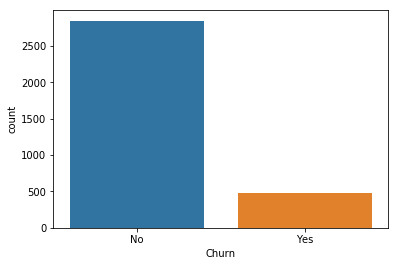

In [8]:
import seaborn as sns
sns.countplot(x="Churn", data=df)

## Part 1.2: Data cleaning

#### Feature 'TotalRevenue' is mistakenly recoginized as text columns with missing values.

In [9]:
df['TotalRevenue'] = pd.to_numeric(df['TotalRevenue'].tolist(), errors='coerce')
df.dropna(subset=['TotalRevenue'], how='any', inplace = True)

text_cols = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]
df[text_cols] = df[text_cols].applymap(lambda x: x.strip())

#### Define binary_cols (1 or 0), numeric_cols (ordinal int and float), enc_cols (text requiring encoding) and y_cols

In [11]:
all_cols = df.columns.tolist()
y_cols = ['Churn']
to_drop_cols = ['customerID', 'PhoneService']  # PhoneService is all 'Yes' in data
yes_no_cols = ['MaritalStatus', 'Dependents', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
               'StreamingMovies','PaperlessBilling', 'InternationalPlan', 'VoiceMailPlan', ]
one_zero_cols = ['SeniorCitizen']
text_cols = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]

binary_cols = yes_no_cols + one_zero_cols
enc_cols = [item for item in text_cols if item not in yes_no_cols+y_cols+to_drop_cols]
numeric_cols = [i for i in all_cols if i not in y_cols+to_drop_cols+binary_cols+enc_cols]

# Step 1: drop to_drop_cols
df_processed = df.drop(to_drop_cols, axis=1)
# Step 2: Change yes_no_cols values to 1 or 0. Merge yes_no_cols and one_zero_cols
df_processed[yes_no_cols] = df_processed[yes_no_cols].applymap(lambda x: 1 if x == 'Yes' else 0)
# Step 3: change y_cols values to 1 or 0
df_processed[y_cols] = df_processed[y_cols].applymap(lambda x: 1 if x == 'Yes' else 0)


## Part 1.3:  Understand the features

#### Correlation between numerical values

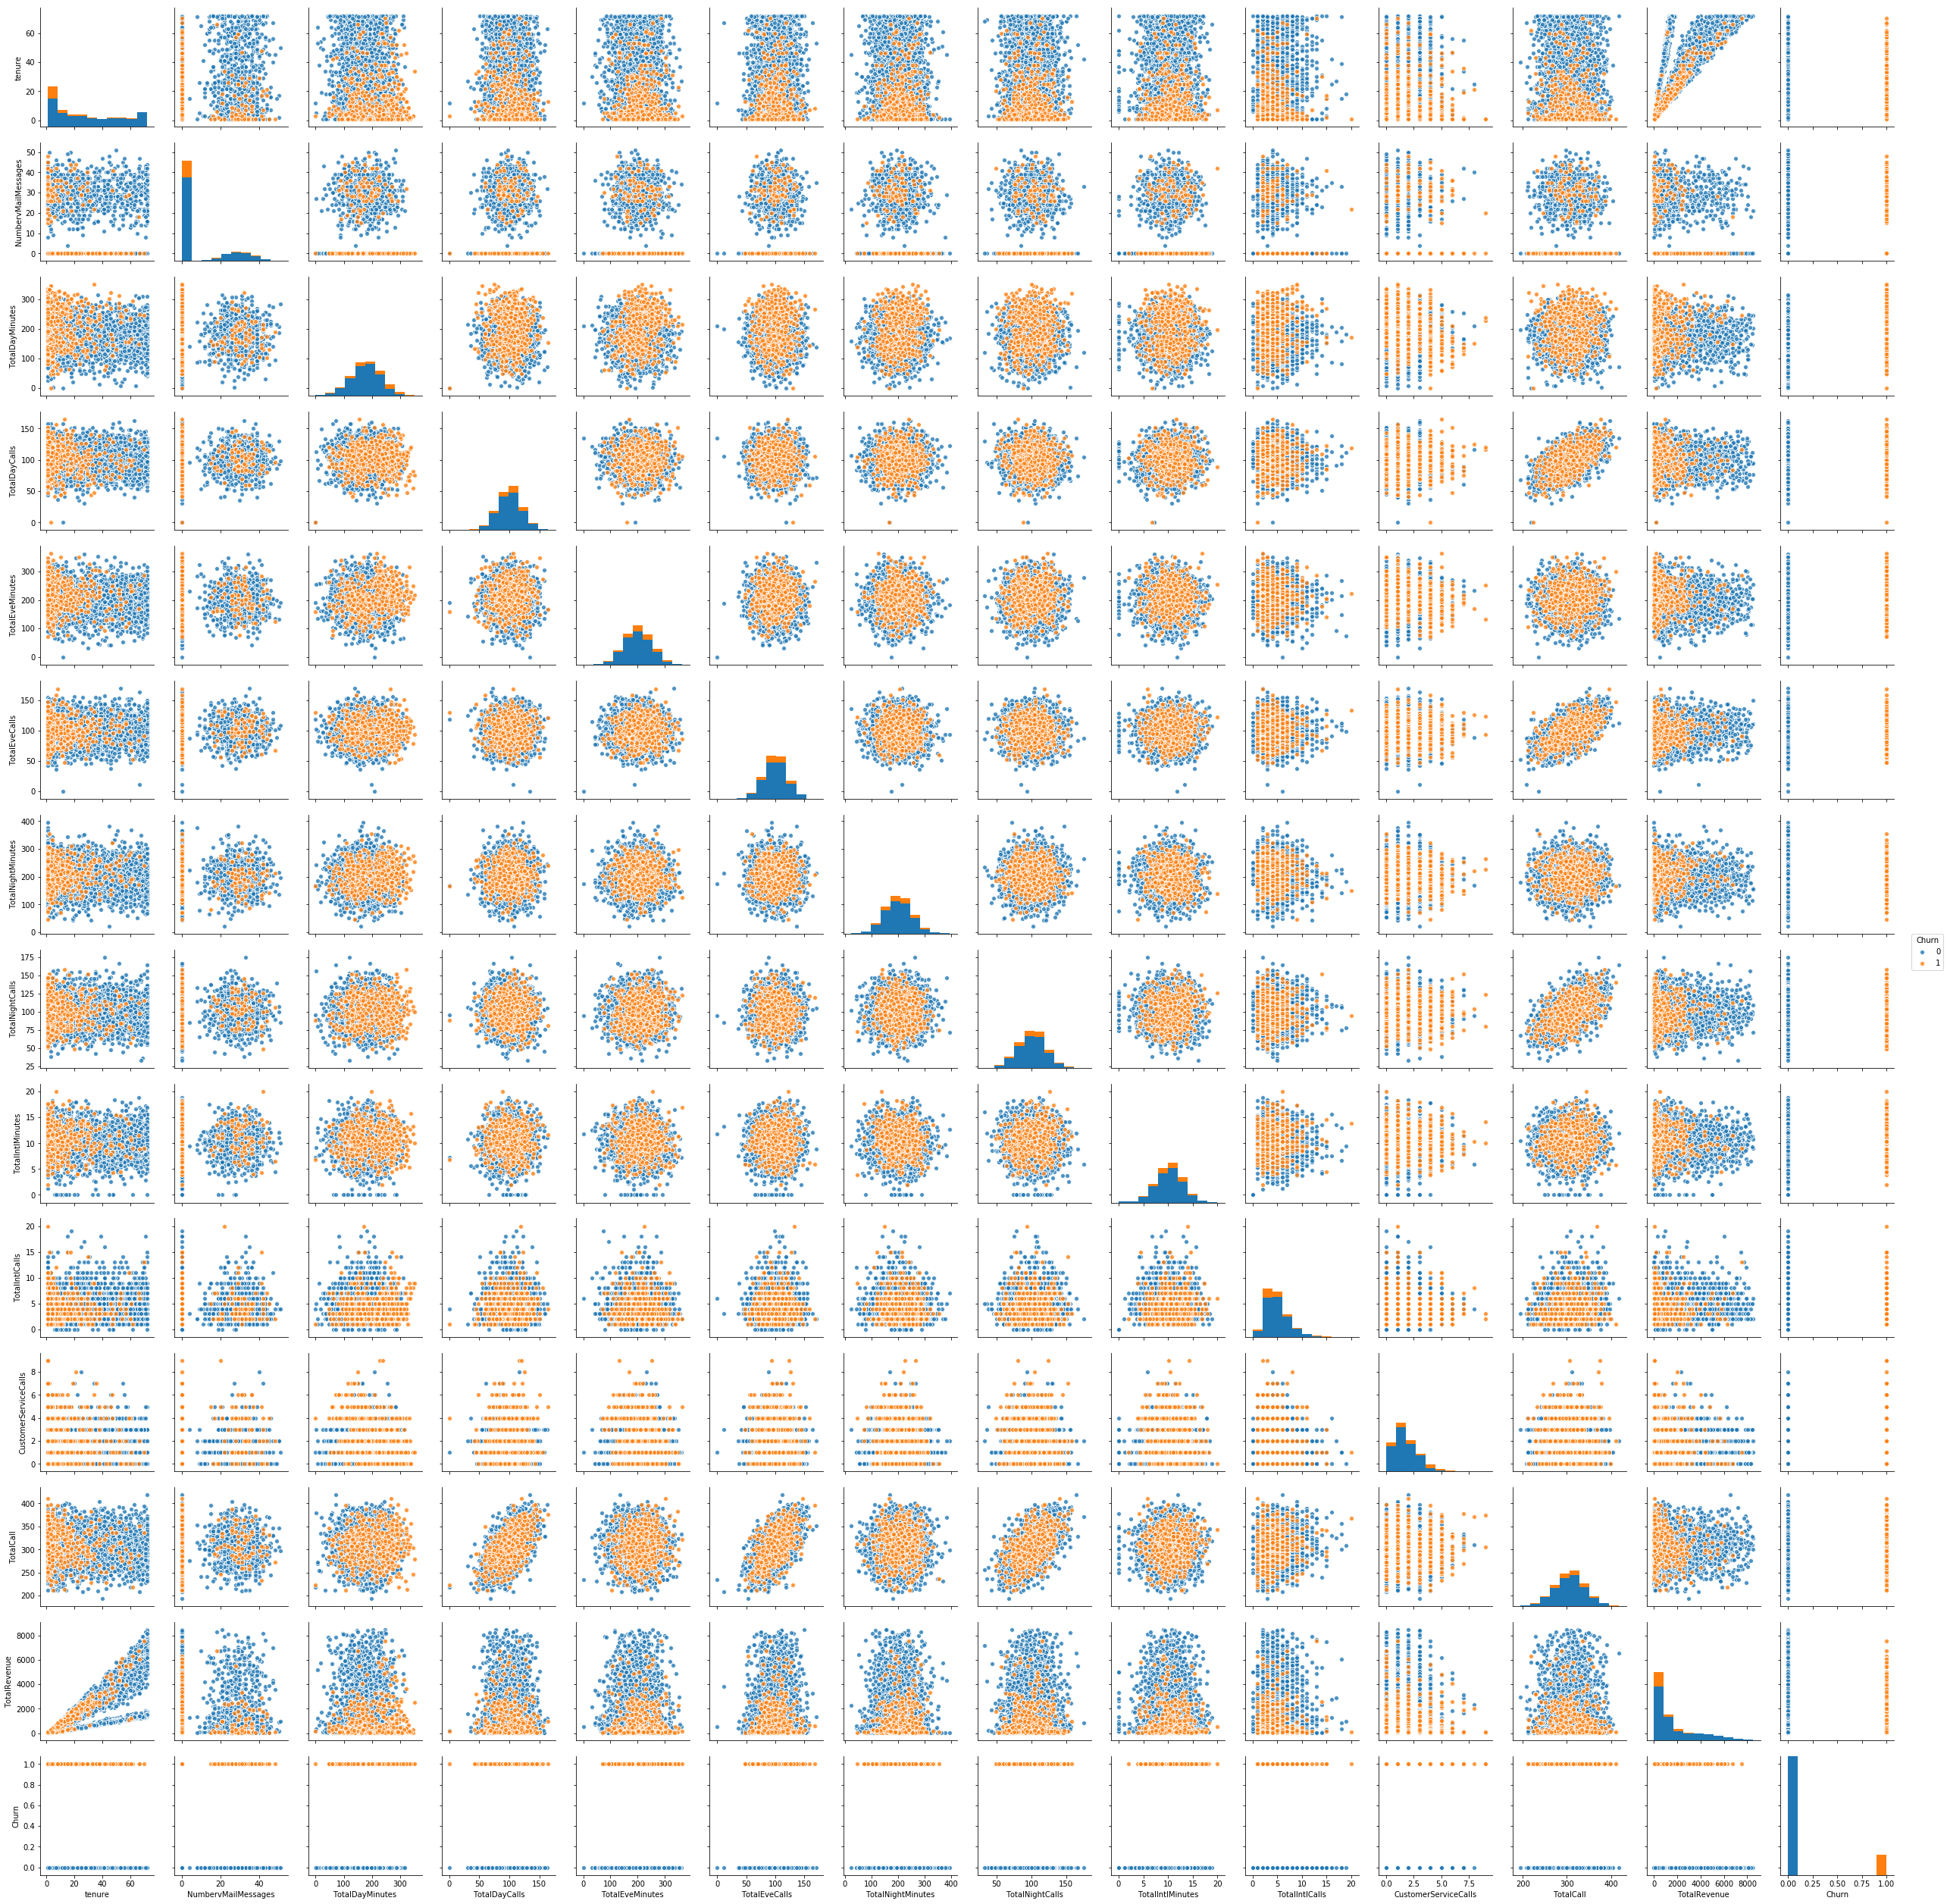

In [12]:
sns.pairplot(df_processed[numeric_cols+y_cols], hue='Churn', hue_order=[0, 1], size=2.5, plot_kws={'alpha': 0.8})

#### Correlation study among features

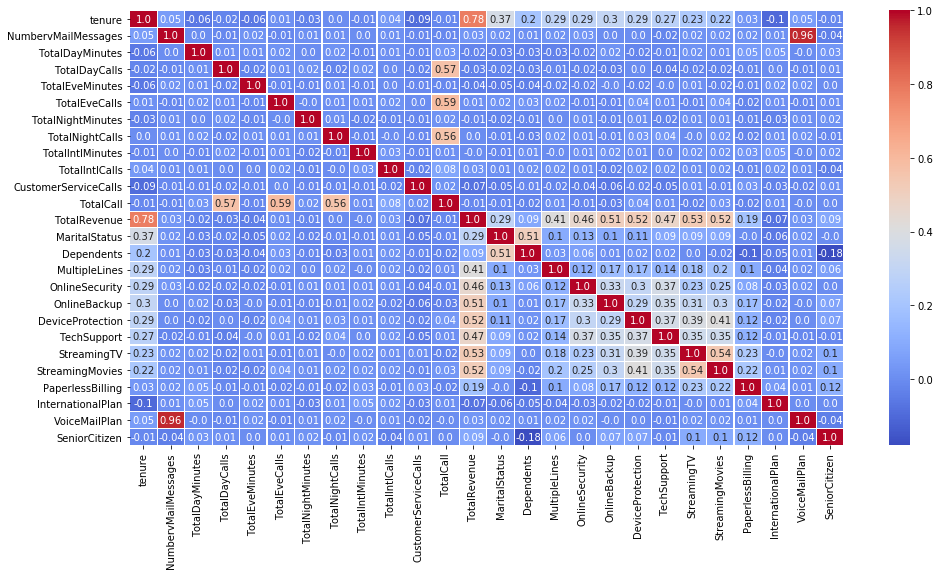

In [14]:
corr = df_processed[numeric_cols+binary_cols].corr()
plt.figure(figsize=(16, 8))
sns.heatmap(round(corr,2), annot=True, fmt='', linewidth=0.2, cmap='coolwarm')

# Part 2: Feature Preprocessing

## Part 2.1 Process features

#### Split y and various x types

In [15]:
y = df_processed[y_cols].values.reshape(-1)
feat_space_numeric = df_processed[numeric_cols]
feat_space_binary = df_processed[binary_cols]
feat_space_enc = df_processed[enc_cols]

#### Apply scaling and one-hot encoding on numeric features and encoding features respectively

In [16]:
def onehot_encoding(df_in, list_in):
    """
    Apply onehot encoding to a dataframe only on the provided columns
    Arg: df_in: dataframe
         list_in: list of column names
    Return: dataframe with encoding columns   
    """
    generated_ohe_list = []
    for i_ in list_in:
        dummies = pd.get_dummies(df_in[i_], prefix=i_)   # dummies only contains new cols
        generated_ohe_list.extend([j_ for j_ in list(dummies) if j_.startswith(i_)])  # Get generated new col names
        df_in = pd.concat([df_in, dummies], axis=1)
        df_in.loc[df_in[i_].isnull(), df_in.columns.str.startswith(i_)] = np.nan
  
    return df_in, generated_ohe_list   # Return input df + new cols, new col names#

from sklearn.preprocessing import StandardScaler

# Scaling numeric features 
X_numeric = feat_space_numeric.as_matrix().astype(np.float)
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

# One-hot encoding text features
feat_space_enc = onehot_encoding(feat_space_enc, enc_cols)[0]
feat_space_enc = feat_space_enc.drop(enc_cols, axis=1)
X_enc = feat_space_enc.as_matrix().astype(np.float)

# Do nothing to binary features
X_binary = feat_space_binary.as_matrix().astype(np.float)

#### Combine all features into X_comb

In [17]:
X_comb = np.concatenate([X_numeric, X_binary], axis=1)
X_comb = np.concatenate([X_comb, X_enc], axis=1)
print ("Feature space holds %d observations and %d features" % X_comb.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3328 observations and 38 features
Unique target labels: [0 1]


# Part 3: Model Training and Result Evaluation

## Part 3.1: Model selection by K-fold Cross-Validation and Confusion Matrix

In [34]:
from sklearn.cross_validation import KFold

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X, y, clf_class, **kwargs):
    # Construct a kfolds object
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


accuracy = lambda y_true, y_pred: np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_L1_CV_result = run_cv(X_comb, y, LogisticRegression, penalty='l1') # default C = 1/lambda = 1 
LR_L2_CV_result = run_cv(X_comb, y, LogisticRegression, penalty='l2') # default C = 1/lambda = 1 
RF_CV_result = run_cv(X_comb, y, RandomForestClassifier)
KNN_CV_result = run_cv(X_comb, y, KNeighborsClassifier) #Default: n_neighbors=5
SVM_CV_result = run_cv(X_comb, y, SVC) 
XGB_CV_result = run_cv(X_comb, y, XGBClassifier) 

metric_df = pd.DataFrame([
    ('Logistic regression with L1'), 
    ('Logistic regression with L2'),
    ('Random forest'),
    ('KNN'),
    ('SVM'),
    ('XGBOOST'),
])
metric_df.columns = ['Model Name']

CV_result = [LR_L1_CV_result, LR_L2_CV_result, RF_CV_result, KNN_CV_result, SVM_CV_result, XGB_CV_result]

metric_df['Accuracy'] = pd.Series([accuracy(y, cv) for cv in CV_result])
metric_df['Precision'] = pd.Series([precision_score(y, cv) for cv in CV_result])
metric_df['Recall'] = pd.Series([recall_score(y, cv) for cv in CV_result])
metric_df['F1 score'] = pd.Series([f1_score(y, cv) for cv in CV_result])


metric_df

Model Name  Accuracy  Precision    Recall  F1 score
0  Logistic regression with L1  0.893029   0.690691  0.476190  0.563725
1  Logistic regression with L2  0.893029   0.686217  0.484472  0.567961
2                Random forest  0.913161   0.854015  0.484472  0.618230
3                          KNN  0.893029   0.757085  0.387164  0.512329
4                          SVM  0.916767   0.836601  0.530021  0.648923
5                      XGBOOST  0.947716   0.885287  0.734990  0.803167

#### Confusion Matrix

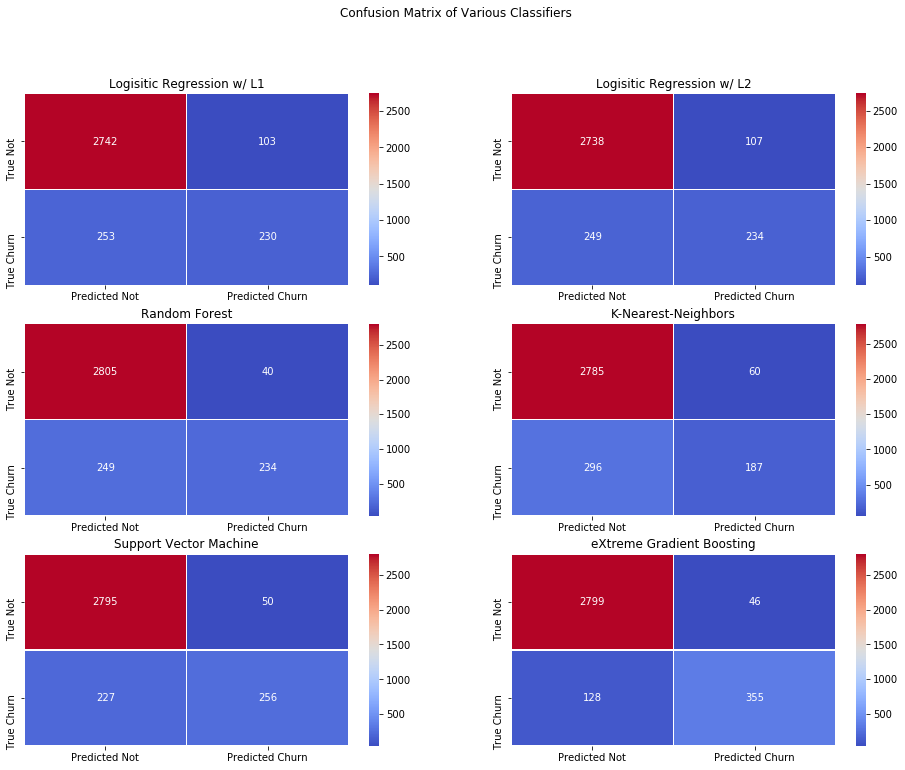

In [20]:
from sklearn.metrics import confusion_matrix

conf_matrix = {
    1: {'matrix': confusion_matrix(y, LR_L1_CV_result),
        'title': 'Logisitic Regression w/ L1',
       },
    2: {'matrix': confusion_matrix(y, LR_L2_CV_result),
        'title': 'Logisitic Regression w/ L2',
       },
    3: {'matrix': confusion_matrix(y, RF_CV_result),
        'title': 'Random Forest',
       },
    4: {'matrix': confusion_matrix(y, KNN_CV_result),
        'title': 'K-Nearest-Neighbors',
       }, 
    5: {'matrix': confusion_matrix(y, SVM_CV_result),
         'title': 'Support Vector Machine'
       },
    6: {'matrix': confusion_matrix(y, XGB_CV_result),
         'title': 'eXtreme Gradient Boosting'
       },  
}

fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
class_names_true = ['True Not','True Churn']
class_names_pred = ['Predicted Not','Predicted Churn']
for i, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    ax = plt.subplot(3, 2, i) # starts from 1
    ax.set_xticklabels([''] + class_names_pred)
    ax.set_yticklabels([''] + class_names_true)
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='', linewidths=.5, cmap='coolwarm', 
                xticklabels=class_names_pred, yticklabels=class_names_true);


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  roc_curve, roc_auc_score

xgb = XGBClassifier(random_state=0)
parameters = {
    'learning_rate': [0.025,0.05,0.1], 
    'max_depth': [3,4,5],
    'subsample': [0.25,0.5,1.0],
    'reg_lambda': [1,2,3], 
    'reg_alpha': [0,1,2]
}

Grid_XGB = GridSearchCV(xgb, parameters, scoring='roc_auc', n_jobs=-1)
Grid_XGB.fit(X_comb, y)
xgb_best = Grid_XGB.best_estimator_
print('Best score: {}'.format(Grid_XGB.best_score_))
print('Best parameters set: \n', Grid_XGB.best_params_)

Best score: 0.9617201899629412
Best parameters set: 
 {'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}


In [24]:
XGB_best_CV_result = run_cv(X_comb, y, XGBClassifier, 
                            learning_rate ='0.1', 
                            max_depth='5',
                            reg_alpha='0', 
                            reg_lambda='1',
                            subsample='1.0')
s = pd.Series({'Model Name': 'XGBOOST optimized', 
               'Accuracy': accuracy(y, XGB_best_CV_result), 
               'Precision': precision_score(y, XGB_best_CV_result), 
               'Recall': recall_score(y, XGB_best_CV_result), 
               'F1 score': f1_score(y, XGB_best_CV_result)})
metric_df.append(s, ignore_index=True)

Model Name  Accuracy  Precision    Recall  F1 score
0  Logistic regression with L1  0.893029   0.690691  0.476190  0.563725
1  Logistic regression with L2  0.893029   0.686217  0.484472  0.567961
2                Random forest  0.913161   0.854015  0.484472  0.618230
3                          KNN  0.893029   0.757085  0.387164  0.512329
4                          SVM  0.916767   0.836601  0.530021  0.648923
5                      XGBOOST  0.947716   0.885287  0.734990  0.803167
6            XGBOOST optimized  0.956130   0.933162  0.751553  0.832569

# Part 4: Feature Importance

## Part 4.1:  Feature importance of XGBOOST and random forest models

In [25]:
# Plot importance vs feature
def plot_importance(feature_names, importance):
    df_tmp = pd.DataFrame([[k, abs(v)/ max(abs(importance))] 
                           for k, v in zip(feature_names, importance)])
    df_tmp.columns = ['feature', 'importance']
    df_tmp = df_tmp.sort_values(['importance'], ascending=[False])
    plt.figure(figsize=(8, 10))
    sns.barplot(x='importance', y='feature', data=df_tmp, orient='h')

all_feature_list = feat_space_numeric.columns.tolist()+feat_space_binary.columns.tolist()+feat_space_enc.columns.tolist()

#### XGBOOST

(38,)


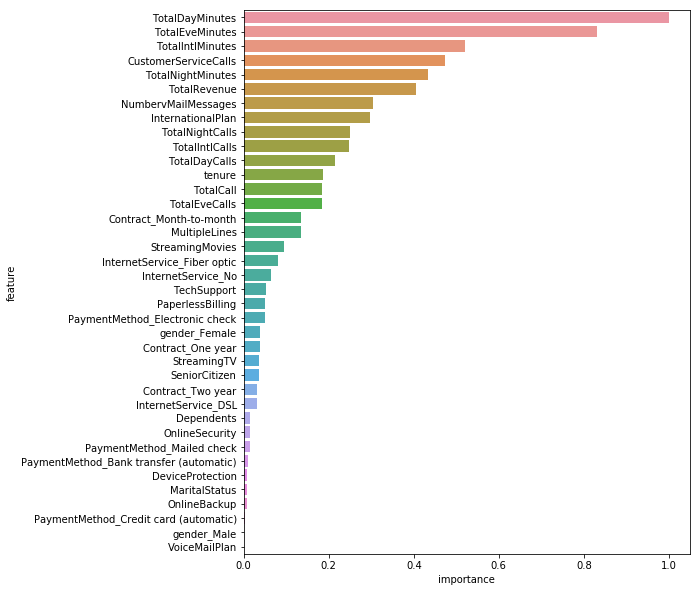

In [26]:
model = xgb_best
print(model.feature_importances_.shape)
plot_importance(all_feature_list, model.feature_importances_)

#### Random forest

(38,)


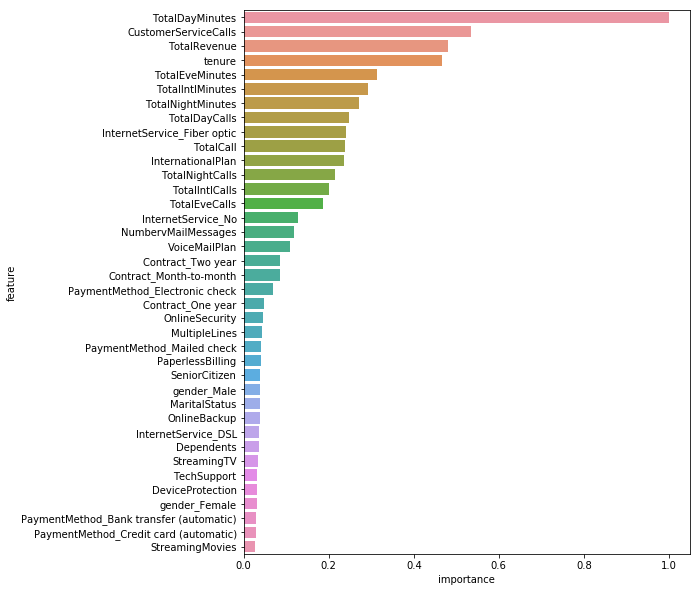

In [27]:
model = RandomForestClassifier()
model.fit(X_comb, y)
print(model.feature_importances_.shape)
plot_importance(all_feature_list, model.feature_importances_)

## Part 4.3: Top important feature study from XGBOOST

In [23]:
def plot_dist(df, feature_name):
    churned_data = df.loc[df['Churn'] == 'Yes']
    not_data = df.loc[df['Churn'] == 'No']
    plt.xlabel(feature_name)
    plt.ylabel('kernel density estimate.')

    sns.distplot(churned_data [feature_name], label='churned')
    sns.distplot(not_data[feature_name], label='not churned')
    plt.legend()

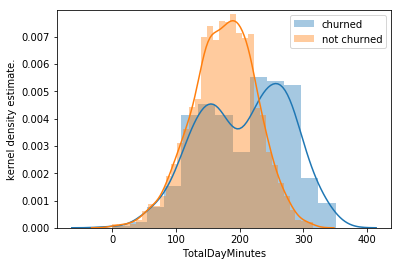

In [28]:
plot_dist(df, 'TotalDayMinutes')

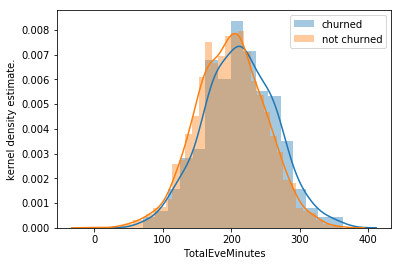

In [29]:
plot_dist(df, 'TotalEveMinutes')

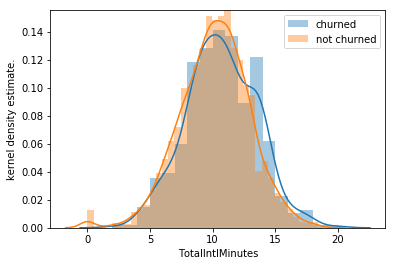

In [30]:
plot_dist(df, 'TotalIntlMinutes')

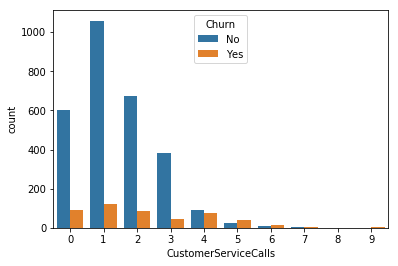

In [32]:
sns.countplot(x='CustomerServiceCalls', hue='Churn', data=df)